In [13]:
import warnings
import fiftyone
from fiftyone import ViewField as F
warnings.filterwarnings('ignore')
dataset = fiftyone.zoo.load_zoo_dataset("coco-2017",max_samples=500)

animal_images = dataset.filter_labels("ground_truth", F("supercategory")=="animal")

#session = fiftyone.launch_app(animal_images)

Found annotations at '/Users/adrienmonks/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/Users/adrienmonks/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Found test info at '/Users/adrienmonks/fiftyone/coco-2017/raw/image_info_test2017.json'
Sufficient images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017-500'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [14]:
import fiftyone as fo
import fiftyone.zoo as foz
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [16]:
images = []
labels = []

def preprocess_image(image):
    image = tf.image.resize(image, [224, 224]) 
    image = image / 255.0  # Normalize to [0, 1] range
    return image

for sample in animal_images:
    # Read and preprocess the image
    img = tf.io.read_file(sample.filepath)  # Read the image file
    img = tf.image.decode_image(img, channels=3)  # Decode the image
    images.append(preprocess_image(img))  # Preprocess and add to the list
    
    # Extract labels from the ground truth detections
    detections = sample.ground_truth.detections
    labels.append(detections[0].label)  # Use the first label

In [18]:
from sklearn.model_selection import train_test_split

unique_labels = list(set(labels))  # Get unique labels
num_classes = len(unique_labels)    # Number of unique classes
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping

# Convert labels to integers
y_labels = [label_to_int[label] for label in labels]  


X_train, X_val, y_train, y_val = train_test_split(images, y_labels, test_size=0.2, random_state=42)

# Verify the sizes
print(f"Training data size: {len(X_train)}, Training labels size: {len(y_train)}")
print(f"Validation data size: {len(X_val)}, Validation labels size: {len(y_val)}")

X_train = np.array(X_train)
X_val = np.array(X_val)


y_train = np.array(y_train)
y_val = np.array(y_val)


Training data size: 159, Training labels size: 159
Validation data size: 40, Validation labels size: 40


In [19]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
5/5 [==============================] - 3s 466ms/step - loss: 9.5855 - accuracy: 0.0503 - val_loss: 3.0542 - val_accuracy: 0.0750
Epoch 2/10
5/5 [==============================] - 3s 561ms/step - loss: 2.3598 - accuracy: 0.1132 - val_loss: 2.3027 - val_accuracy: 0.2000
Epoch 3/10
5/5 [==============================] - 3s 572ms/step - loss: 2.2600 - accuracy: 0.2516 - val_loss: 2.2889 - val_accuracy: 0.1000
Epoch 4/10
5/5 [==============================] - 3s 504ms/step - loss: 2.0778 - accuracy: 0.3899 - val_loss: 2.3069 - val_accuracy: 0.0750
Epoch 5/10
5/5 [==============================] - 3s 517ms/step - loss: 1.6300 - accuracy: 0.6478 - val_loss: 2.5214 - val_accuracy: 0.1250
Epoch 6/10
5/5 [==============================] - 3s 537ms/step - loss: 1.1185 - accuracy: 0.7484 - val_loss: 2.3227 - val_accuracy: 0.1750
Epoch 7/10
5/5 [==============================] - 2s 484ms/step - loss: 0.6643 - accuracy: 0.8805 - val_loss: 2.3891 - val_accuracy: 0.2500
Epoch 8/10
5/5 [====

In [22]:

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


2/2 [==============================] - 0s 36ms/step - loss: 3.1370 - accuracy: 0.2750
Validation Loss: 3.1370, Validation Accuracy: 0.2750


Matplotlib is building the font cache; this may take a moment.


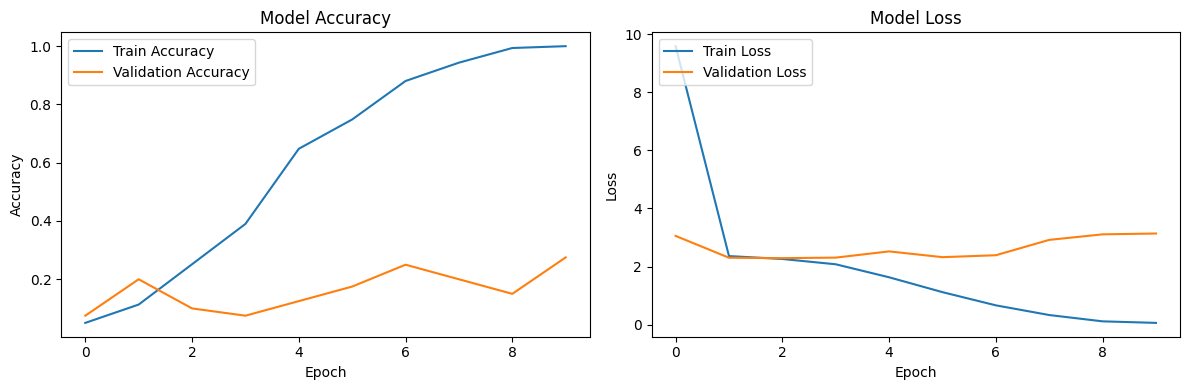

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)
